In [3]:
#| code-fold: true
import matplotlib.pyplot as plt
import torch
import numpy as np

from botorch.acquisition import qLogExpectedImprovement
from botorch.fit import fit_gpytorch_model
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.distributions import Normal

plt.style.use("https://raw.githubusercontent.com/GStechschulte/filterjax/main/docs/styles.mplstyle")

# Outcome constraints

In optimization, it is often the goal that we need to optimize an objective function while satisfying some constraints. For example, we may want to minimize the scrap rate by finding the optimal process parameters of an manufacturing machine. However, we know the scrap rate cannot be below 0. In another setting, we may want to maximize the throughput of a machine, but we know that the throughput cannot exceed the maximum belt speed of the machine. Thus, we need to find regions in the search space that both yield high objective values and satisfy these constraints. In this blog, we will focus on inequality _outcome constraints_. That is, the domain of the objective function is 

$$\text{lower} \le f(x) \le \text{upper}$$

where $\text{lower}$ and $\text{upper}$ are the lower and upper bounds of the objective function. You need not both bounds, but rather one or the other. The set of points $x'$ that satisfy the constraint are called _feasible points_ and the set of points that do not satisfy the constraint are called _infeasible points_. Often, in tutorials and or books teaching Bayesian optimization, it is assumed we know a cost function a priori that restricts the outcome space in some way, and then an additional model is used to model the constraint. However, in practice, we often only know a lower and or upper bound according to technical specifications. These bounds do not require an additional model. 

In this blog, it will be shown how to use BoTorch to optimize a one-dimensional function with an outcome constraint without using an additional model for the cost (constraint) function. The remainder of the post assumes the reader is already familiar with Bayesian optimization.

## Probability of feasibility

In BoTorch it is common to use a Gaussian Process (GP) to model the objective function. The output of the GP is a Gaussian distribution over the predicted values for a given set of input points. It provides not just a single point estimate but a probabilistic prediction that accounts for uncertainty in the predictions. Thus, for each point in the search space, we have a corresponding Gaussian distribution representing the belief of the objective value at that point.

Intuitively, if we have defined an outcome constraint, we can compute the probability that $f(x)$ is feasible by taking the cumulative distribution function (CDF) of the predictive distribution and computing the area between the lower bound and the upper bound. For example, imagine a GP has made a prediction given an input $x$. This predictive distribution is shown below. The prediction is normally distributed around $0.0$ with plausible predictions ranging from $-3$ to $3$. Additionally, there is an outcome constraint of the form

$$0 < f(x)$$

The probability that the prediction is feasible (above $0$) is computed using the CDF of the predictive distribution. In this example, the probability of feasibility is $0.5$. As will be shown below, this probability can then multiplied by the policy score to get the _constrained policy score_.

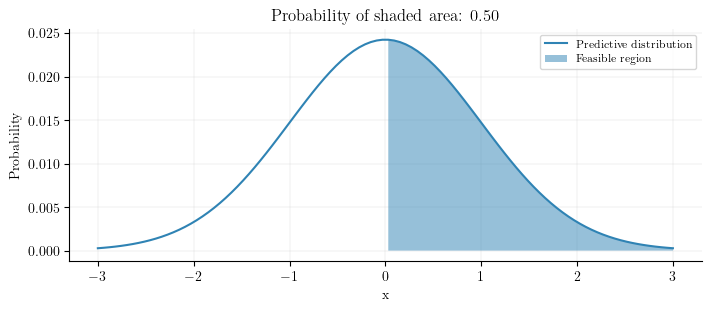

In [32]:
#| code-fold: true
xs = torch.linspace(-3, 3, 100)

normal = Normal(torch.tensor([0.0]), torch.tensor([1.0]))
xs_eval = torch.exp(normal.log_prob(xs)) / torch.exp(normal.log_prob(xs)).sum()

cdf = normal.cdf(xs)
above = torch.where(cdf > 0.5)
prob_feasibility = normal.cdf(torch.zeros(1)).item()

plt.figure(figsize=(7, 3))
plt.plot(xs, xs_eval, label="Predictive distribution")
plt.fill_between(xs, xs_eval, where=xs > 0, alpha=0.5, label="Feasible region")
plt.xlabel('x')
plt.ylabel('Probability')
plt.title(f"Probability of shaded area: {prob_feasibility:.2f}")
plt.legend()
plt.show()


## Constrained Policy

With the probability of feasibility computed, we can scale the policy, e.g. expected improvement (EI), score of each unseen point in the search space by the probability the point is feasible.  

- If the data point is likely to satisfy the constraints, then its EI score will be multiplied by a large number (a high probability of feasibility), thus keeping the EI score high.
- If the data point is unlikely to satisfy the constraints, then its EI score will be multiplied by a small number (a small probability of feasibility), thus keeping the EI score small.

To implement inequality outcome constraints, acquisition functions that utilize Monte-Carlo (MC) sampling are used as this allows us to directly pass a list of constraint callables. These are any acquisition functions that inherit from [SampleReducingMCAcqquisitionFunction](https://github.com/pytorch/botorch/blob/c14808f7a1ce28fdb0e7158e47330b1006687682/botorch/acquisition/monte_carlo.py#L145). 

## Implementation

To implement inequality outcome constraints, only a list of constraint callables which map a Tensor of posterior samples of dimension `sample_shape x batch-shape x q x m`-dim to a `sample_shape x batch-shape x q`-dim Tensor. The associated constraints are considered satisfied if the output is less than zero. In the example below, we aim to minimize the Forrester function subject to the following constraint that
$$f(x) < 0$$ 

_Note_: Since we are minimizing, the objective function is inverted, and thus the inequality is also inverted.

In [34]:
def objective_fn(x):
    return -((x + 1) ** 2) * torch.sin(2 * x + 2) / 5 + 1 + x / 3

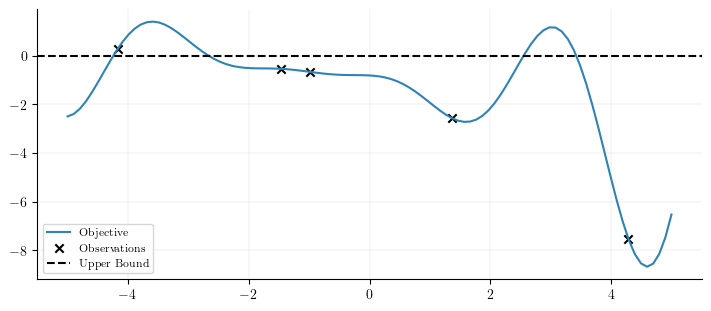

In [41]:
#| code-fold: true
lb, ub = -5, 5
bounds = torch.tensor([[lb], [ub]], dtype=torch.float)
xs = torch.linspace(lb, ub, 100).unsqueeze(1)
ys = -objective_fn(xs)

n = 5
train_x = bounds[0] + (bounds[1] - bounds[0]) * torch.rand(n, 1, dtype=torch.double)
train_y = -objective_fn(train_x)

plt.figure(figsize=(7, 3))
plt.plot(xs, ys, label="Objective")
plt.scatter(train_x, train_y, color="black", label="Observations")
plt.axhline(y=0, color="k", linestyle="--", label="Upper Bound")
plt.legend();

The Bayesian optimization loop below uses the `qLogExpectedImprovement` policy. To impose the desired inequality outcome constraint $f(x) < 0$, a list of callables `[lambda Z: Z.squeeze(-1) - upper]` is passed to `constraints`. This callable subtracts the posterior samples $Z$ by `upper` which is $0.0$. If the result of this is less than zero, then the constraint is satisfied.  

Note that $Z$ here would be passing in all outcomes if a multi-task GP had been defined, so you want to index into $Z$ appropriately and make separate callables for each outcome, e.g.  `constraints=[lambda Z: Z[..., constraint_outcome_idx]]`. However, in this example, there is only one outcome, so we can just use `Z.squeeze(-1)` to select the correct (and only) outcome dimension.

In [ ]:
n_iterations = 20
upper = 0.
for iteration in range(n_iterations):
    print(f"iter: {iteration}")

    model = SingleTaskGP(train_x, train_y, )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)

    logEI = qLogExpectedImprovement(
        model, 
        best_f=train_y[train_y < 0].max(), 
        constraints=[
            lambda Z: Z.squeeze(-1) - upper
            # if there was also a lower bound
            # lambda Z: lower - Z.squeeze(-1),
        ]
    )

    new_x, _ = optimize_acqf(
        acq_function=logEI,
        bounds=bounds,
        q=1,  
        num_restarts=5,
        raw_samples=20,
    )

    new_y = -objective_fn(new_x)

    train_x = torch.cat([train_x, new_x])
    train_y = torch.cat([train_y, new_y])

We can then evaluate the policy on unseen data and plot the proposed points (queries).

In [45]:
with torch.no_grad():
    acquisition_score = logEI(xs.unsqueeze(1))

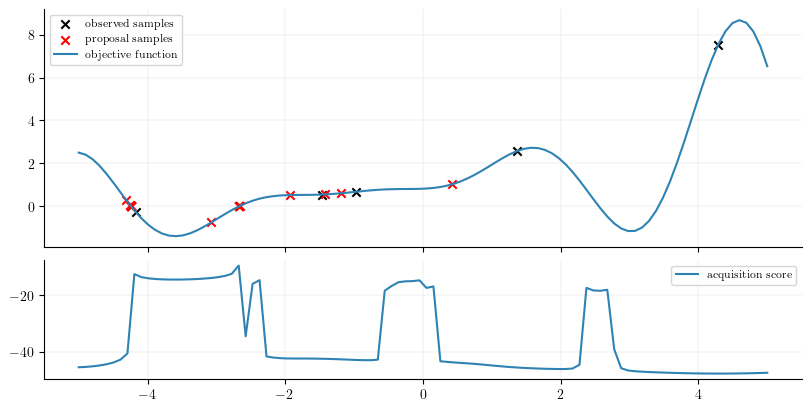

In [48]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(8, 4), 
    sharex=True, 
    gridspec_kw={"height_ratios": [2, 1]}
)

ax[0].scatter(train_x[:5], -train_y[:5], color="black", label="observed samples")
ax[0].scatter(train_x[5:], -train_y[5:], color="red", label="proposal samples")
ax[0].plot(xs, -ys, label="objective function")
ax[0].legend()

ax[1].plot(xs, acquisition_score, label="acquisition score")
ax[1].legend();

The objective function has been flipped back to its original form to visually evaluate the optimization loop. Notice how the majority of the proposed points that minimize the objective function are _near_ $0$. Points that are below $0$ happen due to the fact that we are using a probabilistic surrogate model to compute the probability of feasibility. The predictions of this model are not perfect, and thus, it is possible that the optimized policy score informs the next query to be a point below $0.0$. Nonetheless, the minimizing points are found near $-4.2$, $-2.5$, and $-1.5$.